# Open-Loop Optimal Control

This notebook demonstrates the use of Pyomo for the simulation and computation of open-loop optimal control. The notebook includes a lab exercise.


In [1]:
# Install Pyomo and solvers for Google Colab
import sys
if "google.colab" in sys.modules:
    !wget -N -q https://raw.githubusercontent.com/jckantor/MO-book/main/tools/install_on_colab.py 
    %run install_on_colab.py

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Heater Model

### Model

We will use the two-state model for a single heater/sensor assembly for the calculations that follow.

$$
\begin{align}
C^H_p\frac{dT_{H}}{dt} & = U_a(T_{amb} - T_{H}) + U_b(T_{S} - T_{H}) + \alpha P u\\
C^S_p\frac{dT_{S}}{dt} & = U_b(T_{H} - T_{S}) 
\end{align}
$$

In [3]:
# parameter estimates.
alpha = 0.00016       # watts / (units P * percent U1)
P = 200               # P units
Ua = 0.050            # heat transfer coefficient from heater to environment
CpH = 2.2             # heat capacity of the heater (J/deg C)
CpS = 1.9             # heat capacity of the sensor (J/deg C)
Ub = 0.021            # heat transfer coefficient from heater to sensor
Tamb = 21.0           # ambient temperature

## Simulation

Let's establish a goal of bringing the heater temperature to 60 deg C.  Let's see how well an initial guess at a control strategy will work for us subject to initial conditions

$$
\begin{align*}
T_H(t_0) & = T_{amb} \\
T_S(t_0) & = T_{amb}
\end{align*}
$$

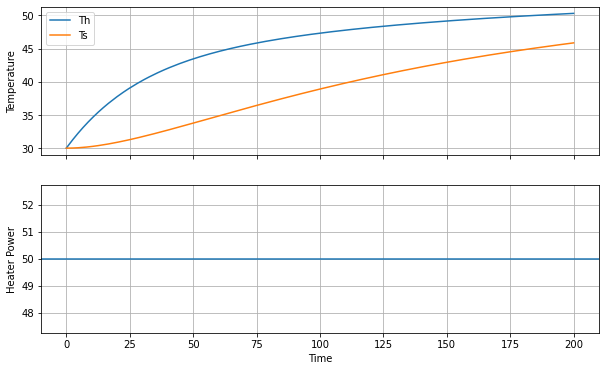

In [4]:
tf = 200
u = 50.0

import pyomo.environ as pyo
import pyomo.dae as dae

m = pyo.ConcreteModel('TCLab Heater/Sensor')

m.t = dae.ContinuousSet(bounds=(0, tf))
m.Th = pyo.Var(m.t)
m.Ts = pyo.Var(m.t)

m.dTh = dae.DerivativeVar(m.Th)
m.dTs = dae.DerivativeVar(m.Ts)

@m.Constraint(m.t)
def heater1(m, t):
    return CpH * m.dTh[t] == Ua *(Tamb - m.Th[t]) + Ub*(m.Ts[t] - m.Th[t]) + alpha*P*u

@m.Constraint(m.t)
def sensor1(m, t):
    return CpS * m.dTs[t] == Ub *(m.Th[t] - m.Ts[t]) 

m.Th[0].fix(30.0)
m.Ts[0].fix(30.0)

pyo.TransformationFactory('dae.collocation').apply_to(m, nfe=50, wrt=m.t)
pyo.SolverFactory('ipopt').solve(m)

fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax[0].plot(m.t, [m.Th[t]() for t in m.t], label="Th")
ax[0].plot(m.t, [m.Ts[t]() for t in m.t], label="Ts")
ax[0].legend()
ax[0].set_ylabel("Temperature")
ax[0].grid()

ax[1].axhline(u, label="Power")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Heater Power")
ax[1].grid()


## Exercises

1. How well did our guess work? Try different guesses and find a value for $u$ that results in a heater temperature close to the target of 60 deg C.

2. What is the impact of simulation time? Is the value determine in question 1 an answer for the power required for a steady state of 60 deg C.

## Control to a Target


How can we set a target value for $T_h$?

What are the 

* additional decision variable(s)?
* what are the additional constraints?
* what is the objective?
* how to modify the Pyomo model?
* how to modify the visualization?

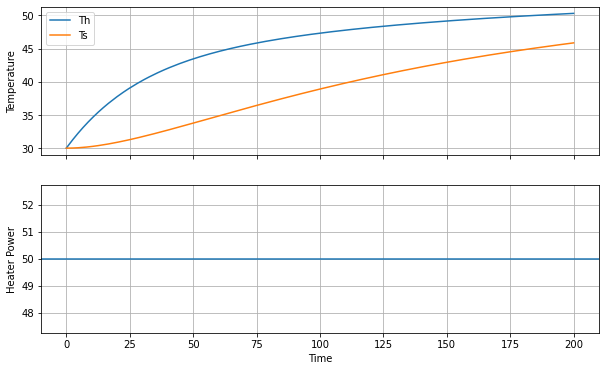

In [6]:
tf = 200
u = 50.0

# Modify this code to find a u so that Th(T_final) = 60.

import pyomo.environ as pyo
import pyomo.dae as dae

m = pyo.ConcreteModel('TCLab Heater/Sensor')

m.t = dae.ContinuousSet(bounds=(0, tf))
m.Th = pyo.Var(m.t)
m.Ts = pyo.Var(m.t)

m.dTh = dae.DerivativeVar(m.Th)
m.dTs = dae.DerivativeVar(m.Ts)

@m.Constraint(m.t)
def heater1(m, t):
    return CpH * m.dTh[t] == Ua *(Tamb - m.Th[t]) + Ub*(m.Ts[t] - m.Th[t]) + alpha*P*u

@m.Constraint(m.t)
def sensor1(m, t):
    return CpS * m.dTs[t] == Ub *(m.Th[t] - m.Ts[t]) 

m.Th[0].fix(30.0)
m.Ts[0].fix(30.0)

pyo.TransformationFactory('dae.collocation').apply_to(m, nfe=50, wrt=m.t)
pyo.SolverFactory('ipopt').solve(m)

fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax[0].plot(m.t, [m.Th[t]() for t in m.t], label="Th")
ax[0].plot(m.t, [m.Ts[t]() for t in m.t], label="Ts")
ax[0].legend()
ax[0].set_ylabel("Temperature")
ax[0].grid()

ax[1].axhline(u, label="Power")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Heater Power")
ax[1].grid()


## Optimal Control

Let's consider the whole approach to steady state

$$\min_u \int_{0}^{t_f} \|SP - T_h(t)\|^2 dt$$

Note that `pyomo.dae` has an `Integral` object to help with these situations.

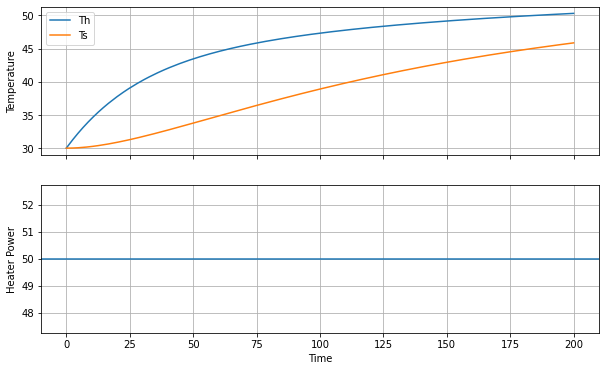

In [8]:
tf = 200
u = 50.0

# Modify this code to find a u so that Th(T_final) = 60.

import pyomo.environ as pyo
import pyomo.dae as dae

m = pyo.ConcreteModel('TCLab Heater/Sensor')

m.t = dae.ContinuousSet(bounds=(0, tf))
m.Th = pyo.Var(m.t)
m.Ts = pyo.Var(m.t)

m.dTh = dae.DerivativeVar(m.Th)
m.dTs = dae.DerivativeVar(m.Ts)

@m.Constraint(m.t)
def heater1(m, t):
    return CpH * m.dTh[t] == Ua *(Tamb - m.Th[t]) + Ub*(m.Ts[t] - m.Th[t]) + alpha*P*u

@m.Constraint(m.t)
def sensor1(m, t):
    return CpS * m.dTs[t] == Ub *(m.Th[t] - m.Ts[t]) 

m.Th[0].fix(30.0)
m.Ts[0].fix(30.0)

pyo.TransformationFactory('dae.collocation').apply_to(m, nfe=50, wrt=m.t)
pyo.SolverFactory('ipopt').solve(m)

fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax[0].plot(m.t, [m.Th[t]() for t in m.t], label="Th")
ax[0].plot(m.t, [m.Ts[t]() for t in m.t], label="Ts")
ax[0].legend()
ax[0].set_ylabel("Temperature")
ax[0].grid()

ax[1].axhline(u, label="Power")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Heater Power")
ax[1].grid()



## Feedforward Optimal Control

An optimal control policy minimizes the differences

$$
\begin{align*}
\min_{u} \int_{t_0}^{t_f} \|T_H^{SP}(t) - T_H(t)\|^2\,dt \\
\end{align*}
$$

subject to constraints

$$
\begin{align*}
C_p^H \frac{dT_H}{dt} & = U_a (T_{amb} - T_H) + U_c (T_S - T_H) + P u(t) + d(t)\\
C_p^S \frac{dT_S}{dt} & = - U_c (T_S - T_H) 
\end{align*}
$$

initial conditions

$$
\begin{align*}
T_H(t_0) & = T_{amb} \\
T_S(t_0) & = T_{amb}
\end{align*}
$$

and prior knowledge of $d(t)$.

### Reference Tractory

The reference trajectory is a sequence of ramp/soak intervals.  Python function `r(t)` uses `numpy.interp` to compute values of the reference trajectory at any point in time.

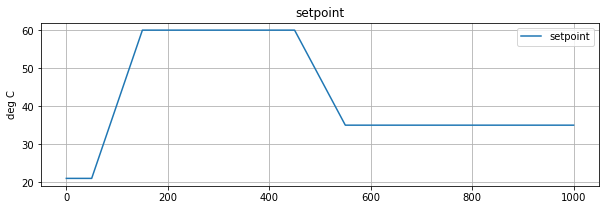

In [9]:
# time grid
tf = 1000
dt = 2
n = round(tf/dt)
t_grid = np.linspace(0, 1000, n+1)

# ambient temperature
Tamb = 21

# setpoint/reference
def r(t):
    return np.interp(t, [0, 50, 150, 450, 550], [Tamb, Tamb, 60, 60, 35])

# plot function
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(t_grid, r(t_grid), label="setpoint")
ax.set_title('setpoint')
ax.set_ylabel('deg C')
ax.legend()
ax.grid(True)